In [1]:
import arviz as az
import matplotlib.pylab as plt
import matplotlib as mpl
#mpl.use('agg')
mpl.style.use('plotting.mplstyle')
import numpy as np
np.random.seed(15)
import json
import os
from read_O3_LVK_results import *
import sys
sys.path.append('./../code/')
from utilities import massModel
from scipy.special import erf
from scipy.stats import gaussian_kde
from tqdm import tqdm

In [2]:
precomputed_data = "stored_Xeff_Xp_data.npy"

if os.path.exists(precomputed_data):
    
    traces = np.load(precomputed_data,allow_pickle=True)[()]
    Xeffs = traces['Xeffs']
    Xps = traces['Xps']
    f_Xeffs = traces['f_Xeffs']
    f_Xps = traces['f_Xps']
    R_ref = traces['R_ref']
    bq = traces['bq']
    alpha = traces['alpha']
    mu_m1 = traces['mu_m1']
    sig_m1 = traces['sig_m1']
    log_f_peak = traces['log_f_peak']
    mMin = traces['mMin']
    mMax = traces['mMax']
    log_dmMin = traces['log_dmMin']
    log_dmMax = traces['log_dmMax']
    
else:

    inference_data = az.from_netcdf("/mnt/ceph/users/tcallister/autoregressive-bbh-inference-data/ar_Xeff_Xp.cdf")
    samps = inference_data.posterior.stack(draws=("chain", "draw"))

    # Also extract mass and mass ratio values
    Xeff_Xp_data = np.load('/mnt/ceph/users/tcallister/autoregressive-bbh-inference-data/ar_Xeff_Xp_data.npy',allow_pickle=True)[()]
    Xeff_values = Xeff_Xp_data['Xeff_allSamples']
    Xp_values = Xeff_Xp_data['Xp_allSamples']

    # For ease of plotting, coarse-grain by a factor of 50
    Xeffs = Xeff_values[::50]
    Xps = Xp_values[::50]

    f_Xeffs = samps['f_Xeffs'].values[::50,:]
    f_Xps = samps['f_Xps'].values[::50,:]

    traces = {
            'Xeffs':Xeffs,
            'Xps':Xps,
            'f_Xeffs':f_Xeffs,
            'f_Xps':f_Xps,
            'R_ref':samps['R20'].values,
            'bq':samps['bq'].values,
            'alpha':samps['alpha'].values,
            'mu_m1':samps['mu_m1'].values,
            'sig_m1':samps['sig_m1'].values,
            'log_f_peak':samps['log_f_peak'].values,
            'mMin':samps['mMin'].values,
            'mMax':samps['mMax'].values,
            'log_dmMin':samps['log_dmMin'].values,
            'log_dmMax':samps['log_dmMax'].values
            }

    np.save('stored_Xeff_Xp_data.npy',traces)

In [4]:
lvk_chiEff_grid,lvk_chiP_grid,lvk_R_ref,lvk_p_Xeff_Xp = get_lvk_gaussian_spin()

Removing  GW170817
Removing  S190425z
Removing  S190426c
Removing  S190814bv
Removing  S190917u
Removing  S200105ae
Removing  S200115j
!!!!!! 64.65302232440014


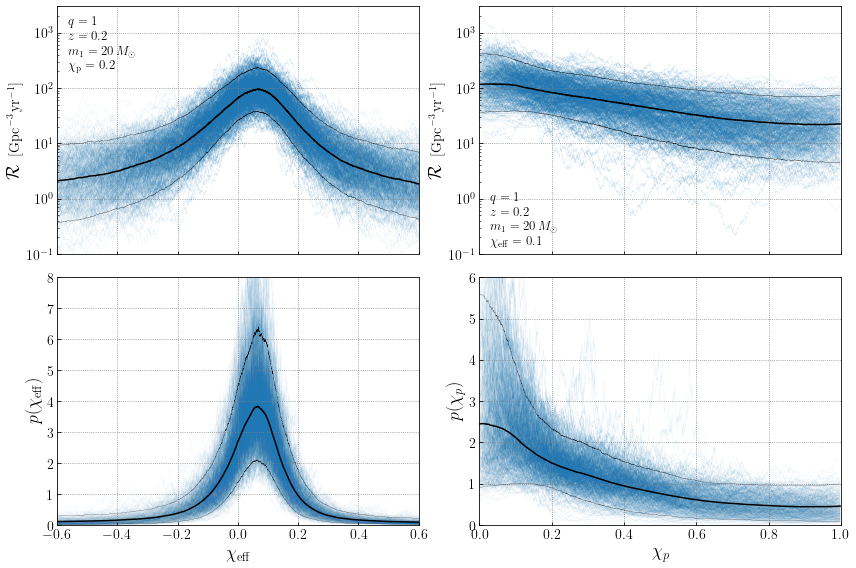

In [10]:
fig = plt.figure(figsize=(12,8))

#########################
ax = fig.add_subplot(221)
ax.set_rasterization_zorder(1)

# Convert to dR/dlnm*dq at m1=20 and q=1
p_q1 = (1.+bq)/(1.-(2./20.)**(1.+bq))
ind_Xp_02 = np.argmin(np.abs(Xps-0.2))
f_Xp_02 = f_Xps[ind_Xp_02,:]
dR_dXeff = R_ref[np.newaxis,:]*f_Xeffs*f_Xp_02*p_q1[np.newaxis,:]*20.
      
for i in np.random.choice(range(dR_dXeff.shape[1]),size=500,replace=False):                 
    ax.plot(Xeffs,dR_dXeff[:,i],color='#1f78b4',alpha=0.2,lw=0.15,zorder=0)
    
ax.plot(Xeffs,np.median(dR_dXeff,axis=1),color='black')
ax.plot(Xeffs,np.quantile(dR_dXeff,0.05,axis=1),color='black',lw=0.3)
ax.plot(Xeffs,np.quantile(dR_dXeff,0.95,axis=1),color='black',lw=0.3)

ax.tick_params(labelsize=14)
ax.set_xlim(-0.6,0.6)
ax.set_ylim(1e-1,3e3)
ax.set_yscale('log')
ax.set_xticklabels([])

ax.text(0.03,0.94,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.88,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.82,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.76,r'$\chi_\mathrm{p}=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)

ax.set_ylabel(r'$\mathcal{R}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}$]}',fontsize=18)

#########################
ax = fig.add_subplot(222)
ax.set_rasterization_zorder(1)

ind_Xeff_01 = np.argmin(np.abs(Xeffs-0.1))
f_Xeff_01 = f_Xeffs[ind_Xeff_01,:]
dR_dXp = R_ref[np.newaxis,:]*f_Xps*f_Xeff_01*p_q1[np.newaxis,:]*20.

for i in np.random.choice(range(dR_dXp.shape[1]),size=500,replace=False):                 
    ax.plot(Xps,dR_dXp[:,i],color='#1f78b4',alpha=0.2,lw=0.2,zorder=0)
    
ax.plot(Xps,np.median(dR_dXp,axis=1),color='black')
ax.plot(Xps,np.quantile(dR_dXp,0.05,axis=1),color='black',lw=0.3)
ax.plot(Xps,np.quantile(dR_dXp,0.95,axis=1),color='black',lw=0.3)

ax.tick_params(labelsize=14)
ax.set_xlim(0,1)
ax.set_ylim(1e-1,3e3)
ax.set_yscale('log')
ax.set_xticklabels([])
ax.set_ylabel(r'$\mathcal{R}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}$]}',fontsize=18)

ax.text(0.03,0.23,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.17,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.11,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.05,r'$\chi_\mathrm{eff} = 0.1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)

#########################
ax = fig.add_subplot(223)
ax.set_rasterization_zorder(1)

p_Xeff = f_Xeffs/np.trapz(f_Xeffs,Xeffs,axis=0)

for i in np.random.choice(range(p_Xeff.shape[1]),size=500,replace=False):                 
    ax.plot(Xeffs,p_Xeff[:,i],color='#1f78b4',alpha=0.1,lw=0.1,zorder=0)
    
ax.plot(Xeffs,np.mean(p_Xeff,axis=1),color='black')
ax.plot(Xeffs,np.quantile(p_Xeff,0.05,axis=1),color='black',lw=0.2)
ax.plot(Xeffs,np.quantile(p_Xeff,0.95,axis=1),color='black',lw=0.2)

ax.tick_params(labelsize=14)
ax.set_xlim(-0.6,0.6)
ax.set_ylim(0,8)

ax.set_xlabel('$\chi_\mathrm{eff}$',fontsize=18)
ax.set_ylabel(r'$p(\chi_\mathrm{eff})$',fontsize=18)

#########################
ax = fig.add_subplot(224)
ax.set_rasterization_zorder(1)

p_Xp = f_Xps/np.trapz(f_Xps,Xps,axis=0)

for i in np.random.choice(range(p_Xp.shape[1]),size=500,replace=False):                 
    ax.plot(Xps,p_Xp[:,i],color='#1f78b4',alpha=0.2,lw=0.1,zorder=0)
    
ax.plot(Xps,np.mean(p_Xp,axis=1),color='black')
ax.plot(Xps,np.quantile(p_Xp,0.05,axis=1),color='black',lw=0.2)
ax.plot(Xps,np.quantile(p_Xp,0.95,axis=1),color='black',lw=0.2)

ax.tick_params(labelsize=14)
ax.set_xlim(0,1)
ax.set_ylim(0,6)

ax.set_xlabel('$\chi_p$',fontsize=18)
ax.set_ylabel(r'$p(\chi_p)$',fontsize=18)

plt.tight_layout()
plt.savefig('Xeff_Xp.pdf',bbox_inches='tight',dpi=200)
plt.show()

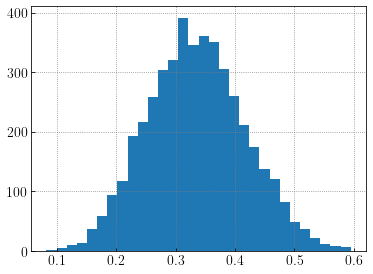

0.3333104339114159 0.14015296650598302 0.13061811971758452


In [18]:
ind_Xeff_00 = np.argmin(np.abs(Xeffs-0.0))

p_neg = np.trapz(p_Xeff[:ind_Xeff_00,:],Xeffs[:ind_Xeff_00],axis=0)

plt.hist(p_neg,bins=30)
plt.show()

print(np.median(p_neg),np.quantile(p_neg,0.95)-np.median(p_neg),np.median(p_neg)-np.quantile(p_neg,0.05))

In [28]:
R_neg = np.zeros(alpha.size)
R_tot = np.zeros(alpha.size)
for i in range(alpha.size):
    
    m1_grid = np.linspace(2,100.,500)
    f_m1 = massModel(m1_grid,
                     alpha[i],mu_m1[i],sig_m1[i],10.**log_f_peak[i],mMax[i],mMin[i],
                     10.**log_dmMax[i],10.**log_dmMin[i])
    f_m1_norm = massModel(20.,
                     alpha[i],mu_m1[i],sig_m1[i],10.**log_f_peak[i],mMax[i],mMin[i],
                     10.**log_dmMax[i],10.**log_dmMin[i])
    
    int_m1 = np.trapz(f_m1/f_m1_norm,m1_grid)
    int_Xeff = np.trapz(f_Xeffs[:,i],Xeffs)
    int_Xp = np.trapz(f_Xps[:,i],Xps)
    
    negative_Xeff = Xeffs<0
    int_neg = np.trapz(f_Xeffs[negative_Xeff,i],Xeffs[negative_Xeff])
        
    R_neg[i] = R_ref[i]*int_m1*int_Xp*int_neg
    R_tot[i] = R_ref[i]*int_m1*int_Xp*int_Xeff
    
print(np.median(R_neg),
      np.quantile(R_neg,0.95)-np.quantile(R_neg,0.5),
      np.quantile(R_neg,0.5)-np.quantile(R_neg,0.05))

9.350860841501579 7.602448631219893 4.452084970786366


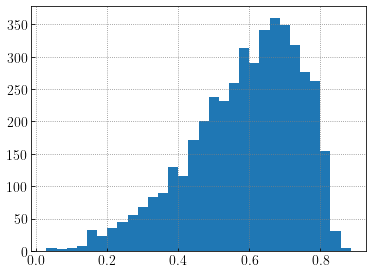

0.612903657895256 0.18283481187747608 0.3200811077959423


In [33]:
ind_Xp_02 = np.argmin(np.abs(Xps-0.2))

p_large = np.trapz(p_Xp[ind_Xp_02:,:],Xps[ind_Xp_02:],axis=0)

plt.hist(p_large,bins=30)
plt.show()

print(np.median(p_large),np.quantile(p_large,0.95)-np.median(p_large),np.median(p_large)-np.quantile(p_large,0.05))

0.976


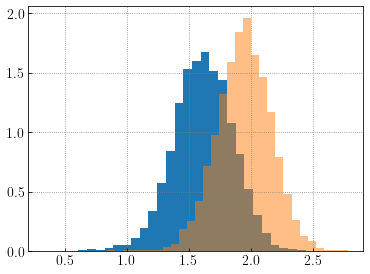

In [55]:
ind_Xeff_n01 = np.argmin(np.abs(Xeffs+0.1))
ind_Xeff_00 = np.argmin(np.abs(Xeffs-0.0))
ind_Xeff_01 = np.argmin(np.abs(Xeffs-0.1))

R_Xeff_n01_to_Xeff_00 = np.trapz(dR_dXeff[ind_Xeff_n01:ind_Xeff_00,:],Xeffs[ind_Xeff_n01:ind_Xeff_00],axis=0)/\
    np.trapz(np.ones(Xeffs[ind_Xeff_n01:ind_Xeff_00].size),Xeffs[ind_Xeff_n01:ind_Xeff_00])
R_Xeff_00_to_Xeff_01 = np.trapz(dR_dXeff[ind_Xeff_00:ind_Xeff_01,:],Xeffs[ind_Xeff_00:ind_Xeff_01],axis=0)/\
    np.trapz(np.ones(Xeffs[ind_Xeff_00:ind_Xeff_01].size),Xeffs[ind_Xeff_00:ind_Xeff_01])

print(R_Xeff_00_to_Xeff_01[R_Xeff_00_to_Xeff_01>R_Xeff_n01_to_Xeff_00].size/R_Xeff_00_to_Xeff_01.size)

fig,ax = plt.subplots()
ax.hist(np.log10(R_Xeff_n01_to_Xeff_00),density=True,bins=30)
ax.hist(np.log10(R_Xeff_00_to_Xeff_01),density=True,bins=30,alpha=0.5)
plt.show()

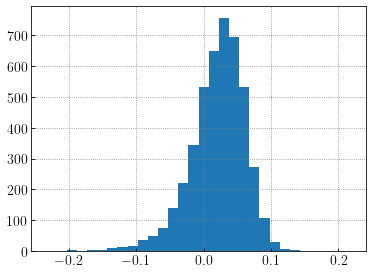

In [35]:
mean_Xeff = np.trapz(Xeffs[:,np.newaxis]*dR_dXeff[:,:],
                     Xeffs,axis=0)/\
    np.trapz(dR_dXeff,Xeffs,axis=0)

plt.hist(mean_Xeff,bins=30)
plt.show()

0.9748888888888889


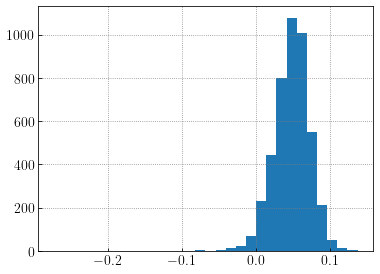

In [34]:
median_Xeffs = np.zeros(dR_dXeff.shape[1])
for i in range(dR_dXeff.shape[1]):
    
    cdf_Xeff = np.cumsum(dR_dXeff[:-1,i]*np.diff(Xeffs))
    cdf_Xeff /= cdf_Xeff[-1]
    
    median_Xeffs[i] = np.interp(0.5,cdf_Xeff,Xeffs[:-1])
    
    
print(median_Xeffs[median_Xeffs>0].size/median_Xeffs.size)
plt.hist(median_Xeffs,bins=30)
plt.show()

2.930100959962807 1.997997997997998
-0.3974535207508635


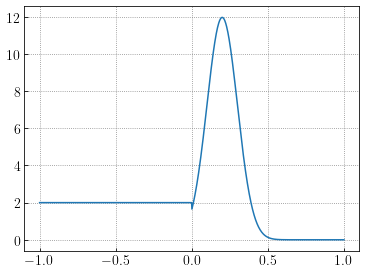

In [53]:
xs = np.linspace(-1,1,1000)
ys = np.zeros(xs.size)
ys[xs<0] = 2
ys[xs>0] = 3.*np.exp(-(xs[xs>0]-0.2)**2/(2.*0.1**2))/np.sqrt(2.*np.pi*0.1**2)

fig,ax = plt.subplots()
ax.plot(xs,ys)

print(np.trapz(ys[xs>0],xs[xs>0]),np.trapz(ys[xs<0],xs[xs<0]))
print(np.trapz(xs*ys,xs))

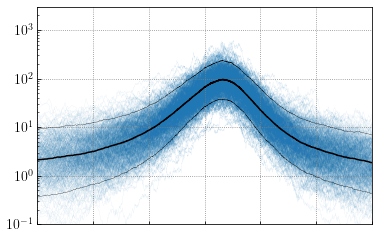

In [29]:
fig = plt.figure(figsize=(6,4))

#########################
ax = fig.add_subplot(111)
ax.set_rasterization_zorder(1)

# Convert to dR/dlnm*dq at m1=20 and q=1
p_q1 = (1.+bq)/(1.-(2./20.)**(1.+bq))
ind_Xp_02 = np.argmin(np.abs(Xps-0.2))
f_Xp_02 = f_Xps[ind_Xp_02,:]
dR_dXeff = R_ref[np.newaxis,:]*f_Xeffs*f_Xp_02*p_q1[np.newaxis,:]*20.
      
for i in np.random.choice(range(dR_dXeff.shape[1]),size=500,replace=False):                 
    ax.plot(Xeffs,dR_dXeff[:,i],color='#1f78b4',alpha=0.2,lw=0.15,zorder=0)
    
ax.plot(Xeffs,np.median(dR_dXeff,axis=1),color='black')
ax.plot(Xeffs,np.quantile(dR_dXeff,0.05,axis=1),color='black',lw=0.3)
ax.plot(Xeffs,np.quantile(dR_dXeff,0.95,axis=1),color='black',lw=0.3)

ax.tick_params(labelsize=14)
ax.set_xlim(-0.6,0.6)
ax.set_ylim(1e-1,3e3)
ax.set_yscale('log')
ax.set_xticklabels([])

plt.show()

In [53]:
component_data = "stored_chi_cost_data.npy"
traces = np.load(component_data,allow_pickle=True)[()]
component_chis = traces['chis']
component_costs = traces['costs']
component_f_chis = traces['f_chis']
component_f_costs = traces['f_costs']
component_R_ref = traces['R_ref']
component_bq = traces['bq']
component_alpha = traces['alpha']
component_mu_m1 = traces['mu_m1']
component_sig_m1 = traces['sig_m1']
component_log_f_peak = traces['log_f_peak']
component_mMin = traces['mMin']
component_mMax = traces['mMax']
component_log_dmMin = traces['log_dmMin']
component_log_dmMax = traces['log_dmMax']

p_chis = component_f_chis/np.trapz(component_f_chis,component_chis,axis=1)[:,np.newaxis]
p_costs = component_f_costs/np.trapz(component_f_costs,component_costs,axis=1)[:,np.newaxis]

chi_cdf = np.cumsum(p_chis[:,1:]*np.diff(component_chis)[np.newaxis,:],axis=1)
chi_cdf /= chi_cdf[:,-1][:,np.newaxis]

cost_cdf = np.cumsum(p_costs[:,1:]*np.diff(component_costs)[np.newaxis,:],axis=1)
cost_cdf /= cost_cdf[:,-1][:,np.newaxis]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:07<00:00, 68.79it/s]


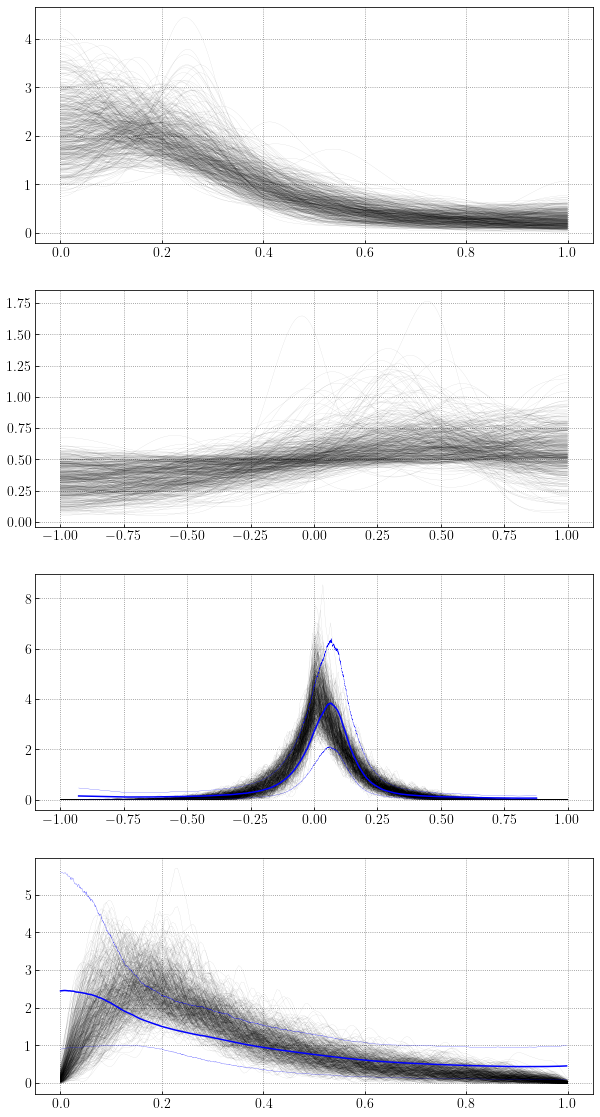

In [56]:
fig = plt.figure(figsize=(10,20))

ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

for i in tqdm(range(500)):
    
    m1_grid = np.linspace(2,100,1000)
    p_m1 = massModel(m1_grid,
              component_alpha[i],
              component_mu_m1[i],
              component_sig_m1[i],
              10.**component_log_f_peak[i],
              component_mMax[i],
              component_mMin[i],
              10.**component_log_dmMax[i],
              10.**component_log_dmMin[i]
              )
    
    p_m1 /= np.trapz(p_m1,m1_grid)
    cdf = np.cumsum(p_m1)*(m1_grid[1]-m1_grid[0])
    
    cdf_draws = np.random.random(1000)
    m1_draws = np.interp(cdf_draws,cdf,m1_grid)
    
    cdf_draws = np.random.random(1000)
    bq = component_bq[i]
    mMin = 2.
    m2_draws = np.power(mMin**(1.+bq) + cdf_draws*(m1_draws**(1.+bq) - mMin**(1.+bq)),1./(1.+bq))
    
    cdf_draws = np.random.random(1000)
    a1_draws = np.interp(cdf_draws,chi_cdf[i,:],component_chis[1:])
    
    cdf_draws = np.random.random(1000)
    a2_draws = np.interp(cdf_draws,chi_cdf[i,:],component_chis[1:])
    
    cdf_draws = np.random.random(1000)
    cost1_draws = np.interp(cdf_draws,cost_cdf[i,:],component_costs[1:])
    
    cdf_draws = np.random.random(1000)
    cost2_draws = np.interp(cdf_draws,cost_cdf[i,:],component_costs[1:])
    
    a_grid = np.linspace(0,1,200)
    cost_grid = np.linspace(-1,1,200)
    Xeff_grid = np.linspace(-1,1,200)
    Xp_grid = np.linspace(0,1,200)
    
    a_kde = gaussian_kde(np.concatenate([a1_draws,a2_draws]))
    ax1.plot(a_grid,a_kde(a_grid)+a_kde(-a_grid)+a_kde(2-a_grid),color='black',lw=0.2,alpha=0.2)
                         
    cost_kde = gaussian_kde(np.concatenate([cost1_draws,cost2_draws]))
    ax2.plot(cost_grid,cost_kde(cost_grid)+cost_kde(-2-cost_grid)+cost_kde(2-cost_grid),
             color='black',lw=0.2,alpha=0.2)
    
    Xeff_draws = (m1_draws*a1_draws*cost1_draws + m2_draws*a2_draws*cost2_draws)/(m1_draws+m2_draws)
    Xeff_kde = gaussian_kde(Xeff_draws,bw_method=0.05)
    ax3.plot(Xeff_grid,Xeff_kde(Xeff_grid)+Xeff_kde(-2-Xeff_grid)+Xeff_kde(2-Xeff_grid),
             color='black',lw=0.2,alpha=0.2)
    
    q_draws = m2_draws/m1_draws
    sint1_draws = np.sqrt(1.-cost1_draws**2)
    sint2_draws = np.sqrt(1.-cost2_draws**2)
    #Xp_draws = (a1_draws*sint1_draws + q_draws*a2_draws*sint2_draws)/(1.+q_draws)
    Xp_draws = np.maximum(a1_draws*sint1_draws,(3.+4.*q_draws)/(4.+3.*q_draws)*q_draws*a2_draws*sint2_draws)
    Xp_kde = gaussian_kde(Xp_draws,bw_method=0.05)
    ax4.plot(Xp_grid,Xp_kde(Xp_grid)+Xp_kde(-2-Xp_grid)+Xeff_kde(2-Xp_grid),
             color='black',lw=0.2,alpha=0.2)
    
ax3.plot(Xeffs,np.mean(p_Xeff,axis=1),color='blue')
ax3.plot(Xeffs,np.quantile(p_Xeff,0.05,axis=1),color='blue',lw=0.2)
ax3.plot(Xeffs,np.quantile(p_Xeff,0.95,axis=1),color='blue',lw=0.2)

ax4.plot(Xps,np.mean(p_Xp,axis=1),color='blue')
ax4.plot(Xps,np.quantile(p_Xp,0.05,axis=1),color='blue',lw=0.2)
ax4.plot(Xps,np.quantile(p_Xp,0.95,axis=1),color='blue',lw=0.2)

In [11]:
lvk_R_Xeff_Xp = lvk_R_ref[:,np.newaxis,np.newaxis]*lvk_p_Xeff_Xp

ind_Xeff_01 = np.argmin(np.abs(lvk_chiEff_grid-0.1))
ind_Xp_02 = np.argmin(np.abs(lvk_chiP_grid-0.2))

lvk_R_Xeff = lvk_R_Xeff_Xp[:,:,ind_Xp_02]
lvk_R_Xp = lvk_R_Xeff_Xp[:,ind_Xeff_01,:]

lvk_p_Xeff = lvk_R_Xeff/np.trapz(lvk_R_Xeff,lvk_chiEff_grid,axis=1)[:,np.newaxis]
lvk_p_Xp = lvk_R_Xp/np.trapz(lvk_R_Xp,lvk_chiP_grid,axis=1)[:,np.newaxis]

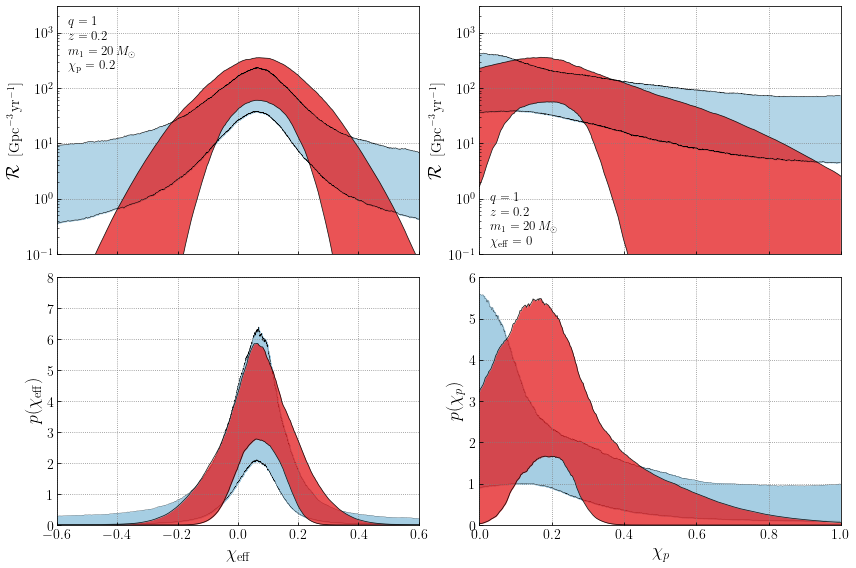

In [12]:
fig = plt.figure(figsize=(12,8))

#########################
ax = fig.add_subplot(221)
ax.set_rasterization_zorder(1)
    
ax.plot(Xeffs,np.quantile(dR_dXeff,0.05,axis=1),color='black',lw=0.5)
ax.plot(Xeffs,np.quantile(dR_dXeff,0.95,axis=1),color='black',lw=0.5)
ax.fill_between(Xeffs,
                np.quantile(dR_dXeff,0.05,axis=1),
                np.quantile(dR_dXeff,0.95,axis=1),
                color='#a6cee3',alpha=0.85,zorder=-1)

ax.plot(lvk_chiEff_grid,np.quantile(lvk_R_Xeff,0.05,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.plot(lvk_chiEff_grid,np.quantile(lvk_R_Xeff,0.95,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.fill_between(lvk_chiEff_grid,
                np.quantile(lvk_R_Xeff,0.05,axis=0),
                np.quantile(lvk_R_Xeff,0.95,axis=0),
                color='#e31a1c',alpha=0.75,zorder=1,lw=0)

ax.tick_params(labelsize=14)
ax.set_xlim(-0.6,0.6)
ax.set_ylim(1e-1,3e3)
ax.set_yscale('log')
ax.set_xticklabels([])

ax.text(0.03,0.94,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.88,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.82,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.76,r'$\chi_\mathrm{p}=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)

ax.set_ylabel(r'$\mathcal{R}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}$]}',fontsize=18)

#########################
ax = fig.add_subplot(222)
ax.set_rasterization_zorder(1)

ax.plot(Xps,np.quantile(dR_dXp,0.05,axis=1),color='black',lw=0.5)
ax.plot(Xps,np.quantile(dR_dXp,0.95,axis=1),color='black',lw=0.5)
ax.fill_between(Xps,
                np.quantile(dR_dXp,0.05,axis=1),
                np.quantile(dR_dXp,0.95,axis=1),
                color='#a6cee3',alpha=0.85,zorder=-1)

ax.plot(lvk_chiP_grid,np.quantile(lvk_R_Xp,0.05,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.plot(lvk_chiP_grid,np.quantile(lvk_R_Xp,0.95,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.fill_between(lvk_chiP_grid,
                np.quantile(lvk_R_Xp,0.05,axis=0),
                np.quantile(lvk_R_Xp,0.95,axis=0),
                color='#e31a1c',alpha=0.75,zorder=1,lw=0)

ax.tick_params(labelsize=14)
ax.set_xlim(0,1)
ax.set_ylim(1e-1,3e3)
ax.set_yscale('log')
ax.set_xticklabels([])
ax.set_ylabel(r'$\mathcal{R}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}$]}',fontsize=18)

ax.text(0.03,0.23,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.17,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.11,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.05,r'$\chi_\mathrm{eff} = 0$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)

#########################
ax = fig.add_subplot(223)
ax.set_rasterization_zorder(1)

ax.plot(Xeffs,np.quantile(p_Xeff,0.05,axis=1),color='black',lw=0.3,zorder=0)
ax.plot(Xeffs,np.quantile(p_Xeff,0.95,axis=1),color='black',lw=0.2,zorder=0)
ax.fill_between(Xeffs,
                np.quantile(p_Xeff,0.05,axis=1),
                np.quantile(p_Xeff,0.95,axis=1),
                color='#a6cee3',alpha=1,zorder=-1)

ax.plot(lvk_chiEff_grid,np.quantile(lvk_p_Xeff,0.05,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.plot(lvk_chiEff_grid,np.quantile(lvk_p_Xeff,0.95,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.fill_between(lvk_chiEff_grid,
                np.quantile(lvk_p_Xeff,0.05,axis=0),
                np.quantile(lvk_p_Xeff,0.95,axis=0),
                color='#e31a1c',alpha=0.75,zorder=1,lw=0)

ax.tick_params(labelsize=14)
ax.set_xlim(-0.6,0.6)
ax.set_ylim(0,8)

ax.set_xlabel('$\chi_\mathrm{eff}$',fontsize=18)
ax.set_ylabel(r'$p(\chi_\mathrm{eff})$',fontsize=18)

#########################
ax = fig.add_subplot(224)
ax.set_rasterization_zorder(1)

ax.plot(Xps,np.quantile(p_Xp,0.05,axis=1),color='black',lw=0.3,zorder=0)
ax.plot(Xps,np.quantile(p_Xp,0.95,axis=1),color='black',lw=0.2,zorder=0)
ax.fill_between(Xps,
                np.quantile(p_Xp,0.05,axis=1),
                np.quantile(p_Xp,0.95,axis=1),
                color='#a6cee3',alpha=1,zorder=-1)

ax.plot(lvk_chiP_grid,np.quantile(lvk_p_Xp,0.05,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.plot(lvk_chiP_grid,np.quantile(lvk_p_Xp,0.95,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.fill_between(lvk_chiP_grid,
                np.quantile(lvk_p_Xp,0.05,axis=0),
                np.quantile(lvk_p_Xp,0.95,axis=0),
                color='#e31a1c',alpha=0.75,zorder=1,lw=0)

ax.tick_params(labelsize=14)
ax.set_xlim(0,1)
ax.set_ylim(0,6)

ax.set_xlabel('$\chi_p$',fontsize=18)
ax.set_ylabel(r'$p(\chi_p)$',fontsize=18)

plt.tight_layout()
plt.savefig('Xeff_Xp_comparison.pdf',bbox_inches='tight',dpi=200)
plt.show()

Text(0, 0.5, '$\\mathcal{R}$ \\,{\\Large[$\\mathrm{Gpc}^{-3}\\,\\mathrm{yr}^{-1}$]}')

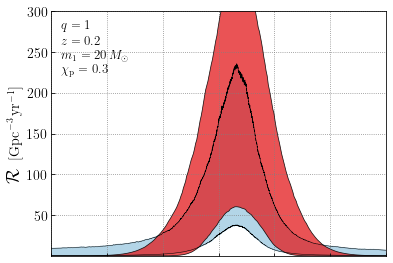

In [8]:
fig = plt.figure()

#########################
ax = fig.add_subplot(111)
ax.set_rasterization_zorder(1)
    
ax.plot(Xeffs,np.quantile(dR_dXeff,0.05,axis=1),color='black',lw=0.5)
ax.plot(Xeffs,np.quantile(dR_dXeff,0.95,axis=1),color='black',lw=0.5)
ax.fill_between(Xeffs,
                np.quantile(dR_dXeff,0.05,axis=1),
                np.quantile(dR_dXeff,0.95,axis=1),
                color='#a6cee3',alpha=0.85,zorder=-1)

ax.plot(lvk_chiEff_grid,np.quantile(lvk_R_Xeff,0.05,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.plot(lvk_chiEff_grid,np.quantile(lvk_R_Xeff,0.95,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.fill_between(lvk_chiEff_grid,
                np.quantile(lvk_R_Xeff,0.05,axis=0),
                np.quantile(lvk_R_Xeff,0.95,axis=0),
                color='#e31a1c',alpha=0.75,zorder=1,lw=0)

ax.tick_params(labelsize=14)
ax.set_xlim(-0.6,0.6)
ax.set_ylim(1e-1,300)
#ax.set_yscale('log')
ax.set_xticklabels([])

ax.text(0.03,0.94,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.88,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.82,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.76,r'$\chi_\mathrm{p}=0.3$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)

ax.set_ylabel(r'$\mathcal{R}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}$]}',fontsize=18)